In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
from tqdm import tqdm

N_POINTS_Y = 15
ASPECT_RATIO = 10
KINEMATIC_VISCOSITY = 0.01
TIME_STEP_LENGTH = 0.001
N_TIME_STEPS = 5000
PLOT_EVERY = 50

N_PRESSURE_POISSON_ITERATIONS = 50

def main():
    cell_length = 1.0 / (N_POINTS_Y - 1)

    n_points_x = (N_POINTS_Y - 1) * ASPECT_RATIO + 1

    x_range = np.linspace(0.0, 1.0 * ASPECT_RATIO, n_points_x)
    y_range = np.linspace(0.0, 1.0, N_POINTS_Y)

    coordinates_x, coordinates_y = np.meshgrid(x_range, y_range)

    # Initial condition
    velocity_x_prev = np.ones((N_POINTS_Y + 1, n_points_x))
    velocity_x_prev[0, :] = - velocity_x_prev[1, :]
    velocity_x_prev[-1, :] = - velocity_x_prev[-2, :]

    velocity_y_prev = np.zeros((N_POINTS_Y, n_points_x+1))

    pressure_prev = np.zeros((N_POINTS_Y+1, n_points_x+1))

    # Pre-Allocate some arrays
    velocity_x_tent = np.zeros_like(velocity_x_prev)
    velocity_x_next = np.zeros_like(velocity_x_prev)

    velocity_y_tent = np.zeros_like(velocity_y_prev)
    velocity_y_next = np.zeros_like(velocity_y_prev)

    plt.style.use("dark_background")
    plt.figure(figsize=(1.5*ASPECT_RATIO, 6))

    for iter in tqdm(range(N_TIME_STEPS)):
        # Update interior of u velocity
        diffusion_x = KINEMATIC_VISCOSITY * (
            (
                +
                velocity_x_prev[1:-1, 2:  ]
                +
                velocity_x_prev[2:  , 1:-1]
                +
                velocity_x_prev[1:-1,  :-2]
                +
                velocity_x_prev[ :-2, 1:-1]
                - 4 *
                velocity_x_prev[1:-1, 1:-1]
            ) / (
                cell_length**2
            )
        )
        convection_x = (
            (
                velocity_x_prev[1:-1, 2:  ]**2
                -
                velocity_x_prev[1:-1,  :-2]**2
            ) / (
                2 * cell_length
            )
            +
            (
                velocity_y_prev[1:  , 1:-2]
                +
                velocity_y_prev[1:  , 2:-1]
                +
                velocity_y_prev[ :-1, 1:-2]
                +
                velocity_y_prev[ :-1, 2:-1]
            ) / 4
            *
            (
                velocity_x_prev[2:  , 1:-1]
                -
                velocity_x_prev[ :-2, 1:-1]
            ) / (
                2 * cell_length
            )
        )
        pressure_gradient_x = (
            (
                pressure_prev[1:-1, 2:-1]
                -
                pressure_prev[1:-1, 1:-2]
            ) / (
                cell_length
            )
        )

        velocity_x_tent[1:-1, 1:-1] = (
            velocity_x_prev[1:-1, 1:-1]
            +
            TIME_STEP_LENGTH
            *
            (
                -
                pressure_gradient_x
                +
                diffusion_x
                -
                convection_x
            )
        )

        # Apply BC
        velocity_x_tent[1:-1, 0] = 1.0
        velocity_x_tent[1:-1, -1] = velocity_x_tent[1:-1, -2]
        velocity_x_tent[0, :] = - velocity_x_tent[1, :]
        velocity_x_tent[-1, :] = - velocity_x_tent[-2, :]

        # Update interior of v velocity
        diffusion_y = KINEMATIC_VISCOSITY * (
            (
                +
                velocity_y_prev[1:-1, 2:  ]
                +
                velocity_y_prev[2:  , 1:-1]
                +
                velocity_y_prev[1:-1,  :-2]
                +
                velocity_y_prev[ :-2, 1:-1]
                -
                4 * velocity_y_prev[1:-1, 1:-1]
            ) / (
                cell_length**2
            )
        )
        convection_y = (
            (
                velocity_x_prev[2:-1, 1:  ]
                +
                velocity_x_prev[2:-1,  :-1]
                +
                velocity_x_prev[1:-2, 1:  ]
                +
                velocity_x_prev[1:-2,  :-1]
            ) / 4
            *
            (
                velocity_y_prev[1:-1, 2:  ]
                -
                velocity_y_prev[1:-1,  :-2]
            ) / (
                2 * cell_length
            )
            +
            (
                velocity_y_prev[2:  , 1:-1]**2
                -
                velocity_y_prev[ :-2, 1:-1]**2
            ) / (
                2 * cell_length
            )
        )
        pressure_gradient_y = (
            (
                pressure_prev[2:-1, 1:-1]
                -
                pressure_prev[1:-2, 1:-1]
            ) / (
                cell_length
            )
        )

        velocity_y_tent[1:-1, 1:-1] = (
            velocity_y_prev[1:-1, 1:-1]
            +
            TIME_STEP_LENGTH
            *
            (
                -
                pressure_gradient_y
                +
                diffusion_y
                -
                convection_y
            )
        )

        # Apply BC
        velocity_y_tent[1:-1, 0] = - velocity_y_tent[1:-1, 1]
        velocity_y_tent[1:-1, -1] = velocity_y_tent[1:-1, -2]
        velocity_y_tent[0, :] = 0.0
        velocity_y_tent[-1, :] = 0.0

        # Compute the divergence as it will be the rhs of the pressure poisson
        # problem
        divergence = (
            (
                velocity_x_tent[1:-1, 1:  ]
                -
                velocity_x_tent[1:-1,  :-1]
            ) / (
                cell_length
            )
            +
            (
                velocity_y_tent[1:  , 1:-1]
                -
                velocity_y_tent[ :-1, 1:-1]
            ) / (
                cell_length
            )
        )
        pressure_poisson_rhs = divergence / TIME_STEP_LENGTH

        # Solve the pressure correction poisson problem
        pressure_correction_prev = np.zeros_like(pressure_prev)
        for _ in range(N_PRESSURE_POISSON_ITERATIONS):
            pressure_correction_next = np.zeros_like(pressure_correction_prev)
            pressure_correction_next[1:-1, 1:-1] = 1/4 * (
                +
                pressure_correction_prev[1:-1, 2:  ]
                +
                pressure_correction_prev[2:  , 1:-1]
                +
                pressure_correction_prev[1:-1,  :-2]
                +
                pressure_correction_prev[ :-2, 1:-1]
                -
                cell_length**2
                *
                pressure_poisson_rhs
            )

            # Apply pressure BC: Homogeneous Neumann everywhere except for the
            # right where is a homogeneous Dirichlet
            pressure_correction_next[1:-1, 0] = pressure_correction_next[1:-1, 1]
            pressure_correction_next[1:-1, -1] = - pressure_correction_next[1:-1, -2]
            pressure_correction_next[0, :] = pressure_correction_next[1, :]
            pressure_correction_next[-1, :] = pressure_correction_next[-2, :]

            # Advance in smoothing
            pressure_correction_prev = pressure_correction_next
        
        # Update the pressure
        pressure_next = pressure_prev + pressure_correction_next

        # Correct the velocities to be incompressible
        pressure_correction_gradient_x = (
            (
                pressure_correction_next[1:-1, 2:-1]
                -
                pressure_correction_next[1:-1, 1:-2]
            ) / (
                cell_length
            )
        )

        velocity_x_next[1:-1, 1:-1] = (
            velocity_x_tent[1:-1, 1:-1]
            -
            TIME_STEP_LENGTH
            *
            pressure_correction_gradient_x
        )

        pressure_correction_gradient_y = (
            (
                pressure_correction_next[2:-1, 1:-1]
                -
                pressure_correction_next[1:-2, 1:-1]
            ) / (
                cell_length
            )
        )

        velocity_y_next[1:-1, 1:-1] = (
            velocity_y_tent[1:-1, 1:-1]
            -
            TIME_STEP_LENGTH
            *
            pressure_correction_gradient_y
        )

        # Again enforce BC
        velocity_x_next[1:-1, 0] = 1.0
        inflow_mass_rate_next = np.sum(velocity_x_next[1:-1, 0])
        outflow_mass_rate_next = np.sum(velocity_x_next[1:-1, -2])
        velocity_x_next[1:-1, -1] = velocity_x_next[1:-1, -2] * inflow_mass_rate_next / outflow_mass_rate_next
        velocity_x_next[0, :] = - velocity_x_next[1, :]
        velocity_x_next[-1, :] = - velocity_x_next[-2, :]

        velocity_y_next[1:-1, 0] = - velocity_y_next[1:-1, 1]
        velocity_y_next[1:-1, -1] = velocity_y_next[1:-1, -2]
        velocity_y_next[0, :] = 0.0
        velocity_y_next[-1, :] = 0.0

        # Advance in time
        velocity_x_prev = velocity_x_next
        velocity_y_prev = velocity_y_next
        pressure_prev = pressure_next

        # inflow_mass_rate_next = np.sum(velocity_x_next[1:-1, 0])
        # outflow_mass_rate_next = np.sum(velocity_x_next[1:-1, -1])
        # print(f"Inflow: {inflow_mass_rate_next}")
        # print(f"Outflow: {outflow_mass_rate_next}")
        # print()

        # Visualization
        if iter % PLOT_EVERY == 0:
            velocity_x_vertex_centered = (
                (
                    velocity_x_next[1:  , :]
                    +
                    velocity_x_next[ :-1, :]
                ) / 2
            )
            velocity_y_vertex_centered = (
                (
                    velocity_y_next[:, 1:  ]
                    +
                    velocity_y_next[:,  :-1]
                ) / 2
            )

            plt.contourf(
                coordinates_x,
                coordinates_y,
                velocity_x_vertex_centered,
                levels=10,
                cmap=cmr.amber,
                vmin=0.0,
                vmax=1.6,
            )
            plt.colorbar()

            plt.quiver(
                coordinates_x[:, ::6],
                coordinates_y[:, ::6],
                velocity_x_vertex_centered[:, ::6],
                velocity_y_vertex_centered[:, ::6],
                alpha=0.4,
            )

            plt.plot(
                5 * cell_length + velocity_x_vertex_centered[:, 5],
                coordinates_y[:, 5], 
                color="black",
                linewidth=3,
            )
            plt.plot(
                20 * cell_length + velocity_x_vertex_centered[:, 20],
                coordinates_y[:, 20], 
                color="black",
                linewidth=3,
            )
            plt.plot(
                80 * cell_length + velocity_x_vertex_centered[:, 80],
                coordinates_y[:, 80], 
                color="black",
                linewidth=3,
            )

            plt.draw()
            plt.pause(0.05)
            plt.clf()
    
    plt.show()

# if __name__ == "__main__":
#     main()

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]

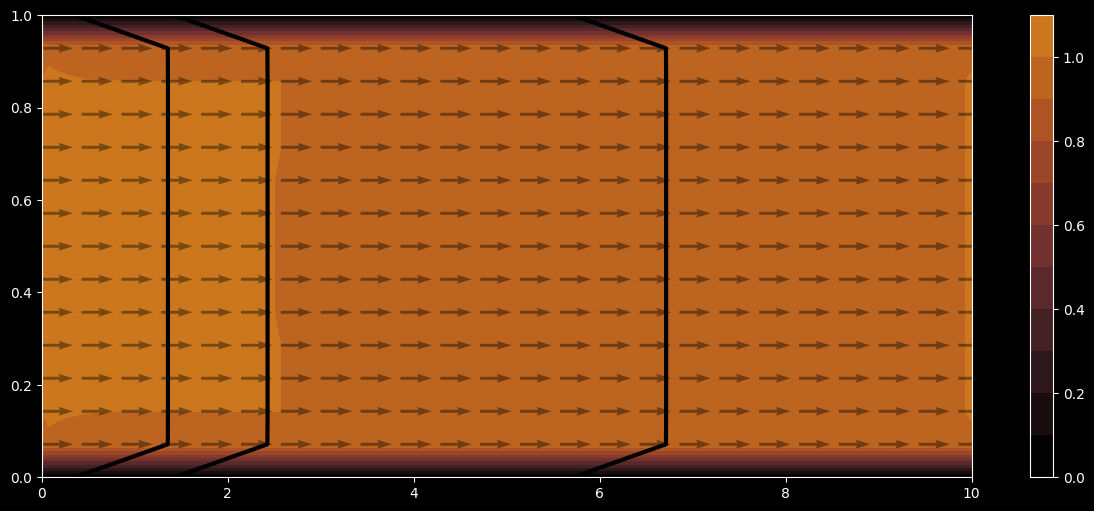

  0%|                                                                                 | 1/5000 [00:00<54:45,  1.52it/s]

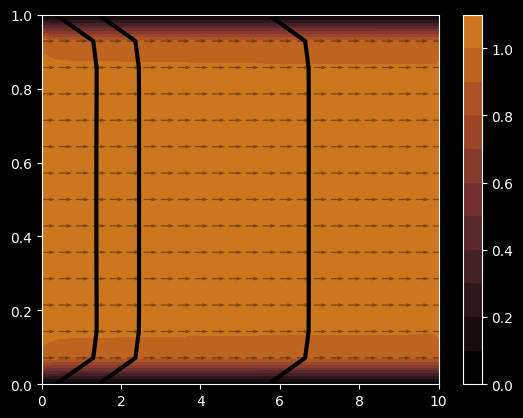

  1%|▊                                                                               | 51/5000 [00:00<01:15, 65.53it/s]

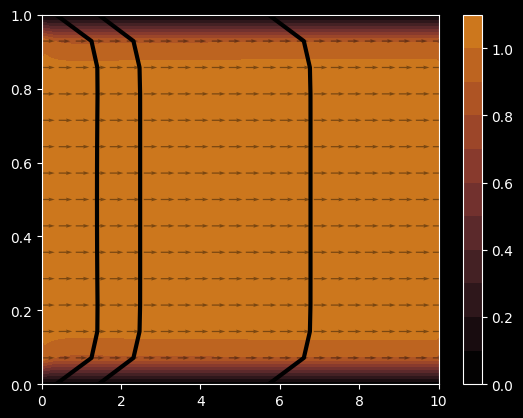

  2%|█▌                                                                            | 101/5000 [00:01<00:48, 100.13it/s]

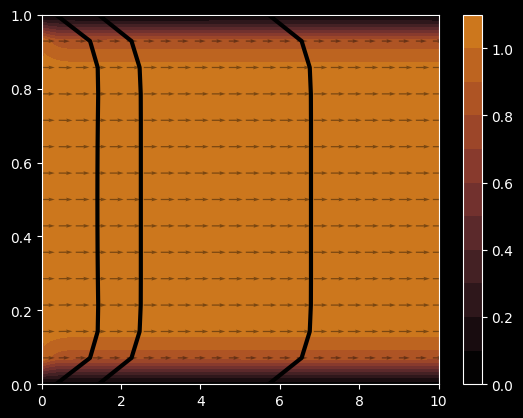

  3%|██▎                                                                           | 151/5000 [00:01<00:42, 114.93it/s]

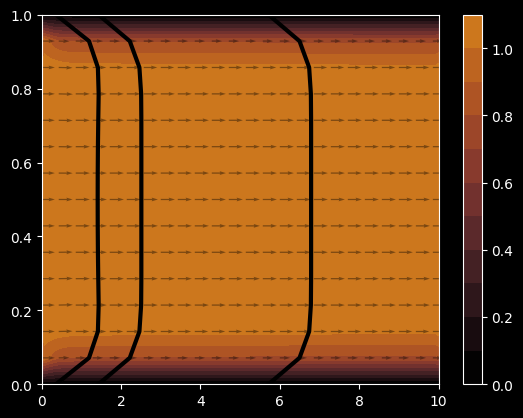

  4%|███▏                                                                          | 201/5000 [00:02<00:40, 119.74it/s]

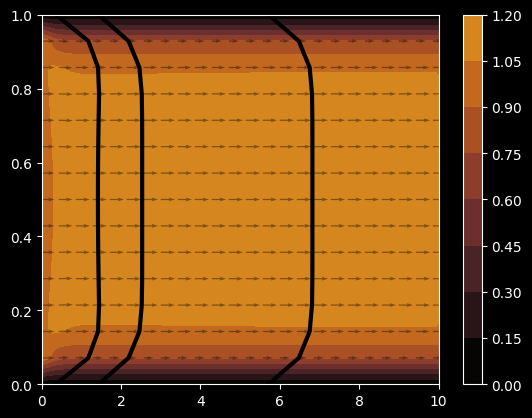

  5%|███▉                                                                          | 251/5000 [00:02<00:36, 129.47it/s]

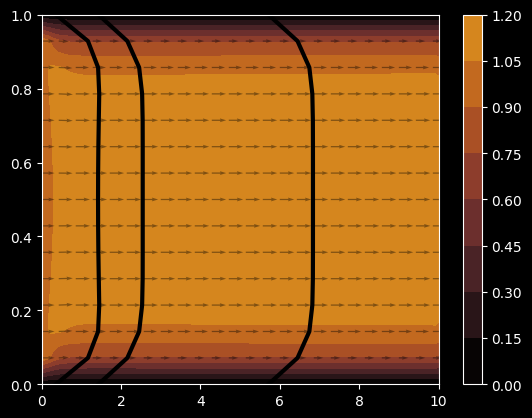

  6%|████▋                                                                         | 301/5000 [00:02<00:35, 132.87it/s]

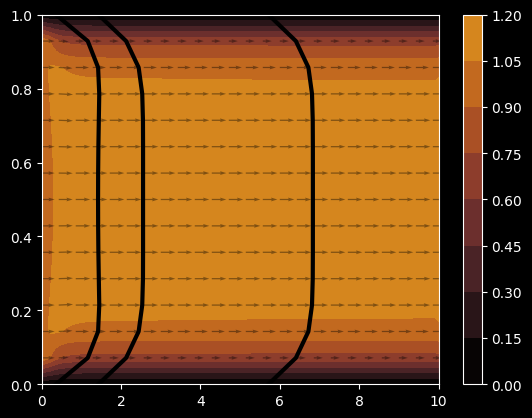

  7%|█████▍                                                                        | 351/5000 [00:03<00:34, 132.92it/s]

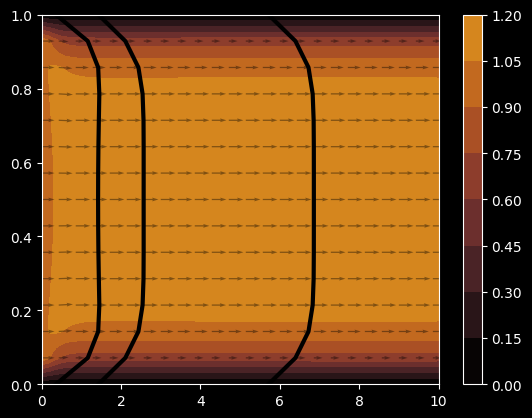

  8%|██████▎                                                                       | 401/5000 [00:03<00:34, 134.72it/s]

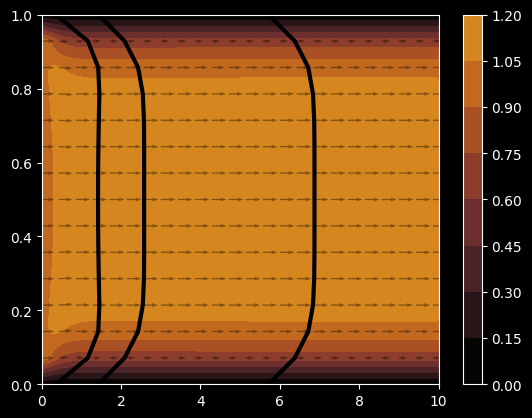

  9%|███████                                                                       | 451/5000 [00:03<00:32, 140.11it/s]

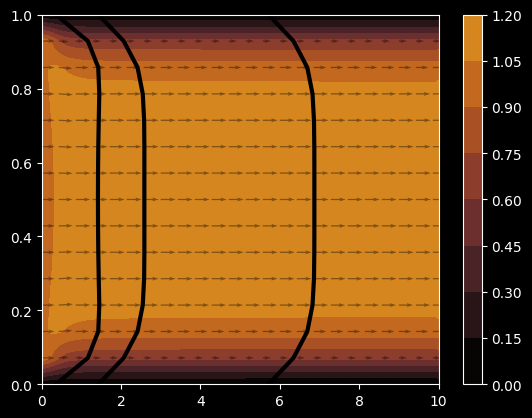

 10%|███████▊                                                                      | 501/5000 [00:04<00:31, 143.55it/s]

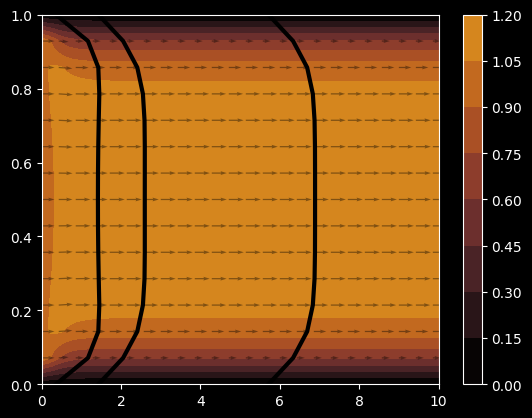

 11%|████████▌                                                                     | 551/5000 [00:04<00:30, 144.51it/s]

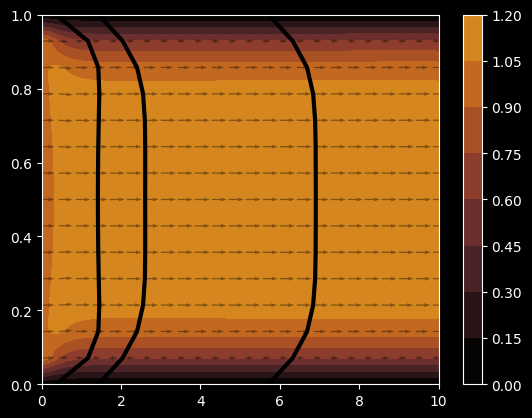

 12%|█████████▍                                                                    | 601/5000 [00:04<00:29, 147.05it/s]

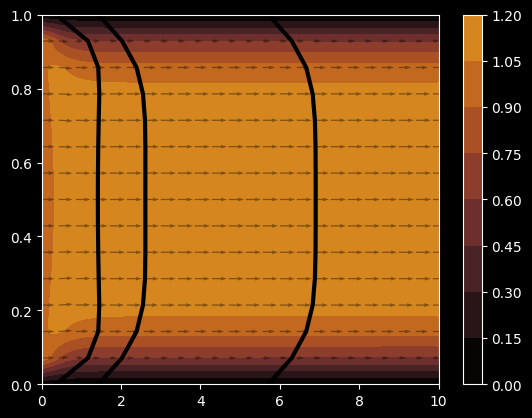

 13%|██████████▏                                                                   | 651/5000 [00:05<00:29, 148.25it/s]

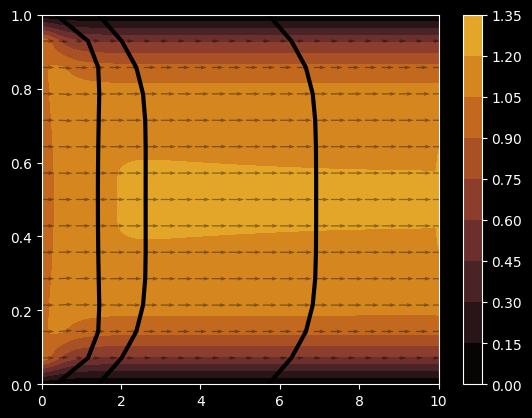

 14%|██████████▉                                                                   | 701/5000 [00:05<00:28, 149.19it/s]

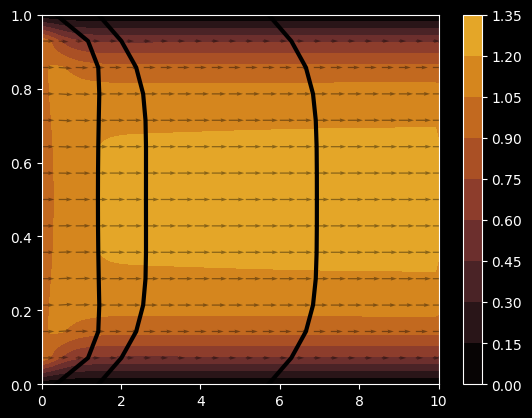

 15%|███████████▋                                                                  | 751/5000 [00:05<00:28, 147.77it/s]

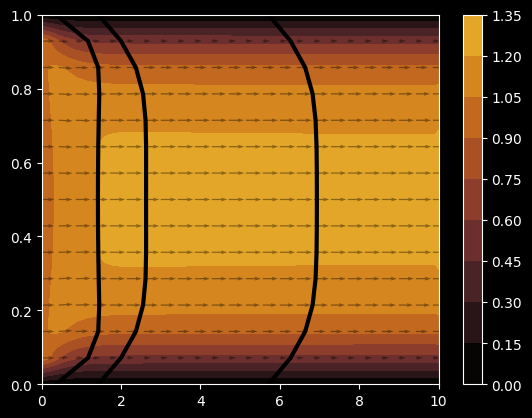

 16%|████████████▍                                                                 | 801/5000 [00:06<00:30, 137.64it/s]

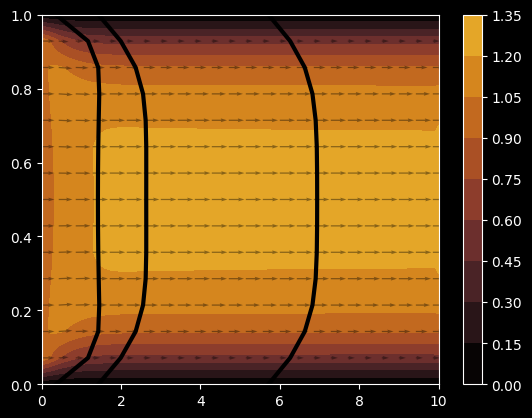

 17%|█████████████▎                                                                | 851/5000 [00:06<00:30, 138.00it/s]

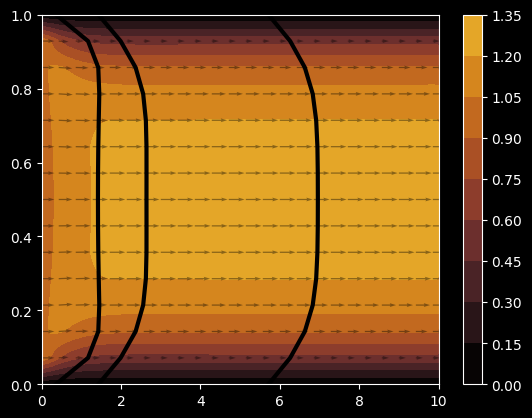

 18%|██████████████                                                                | 901/5000 [00:06<00:29, 138.74it/s]

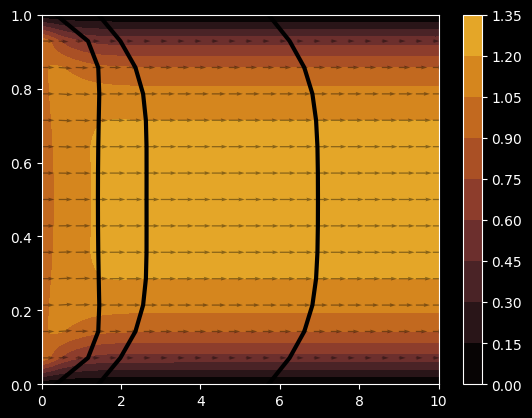

 19%|██████████████▊                                                               | 951/5000 [00:07<00:28, 140.47it/s]

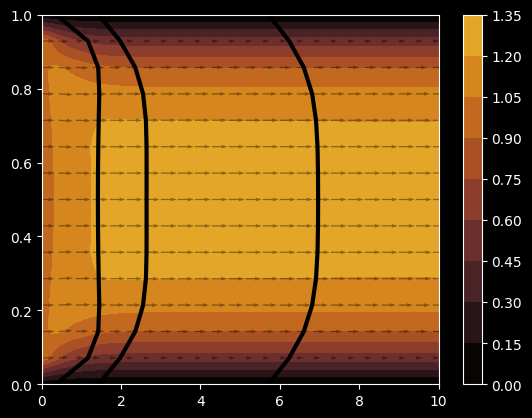

 20%|███████████████▍                                                             | 1001/5000 [00:07<00:28, 141.98it/s]

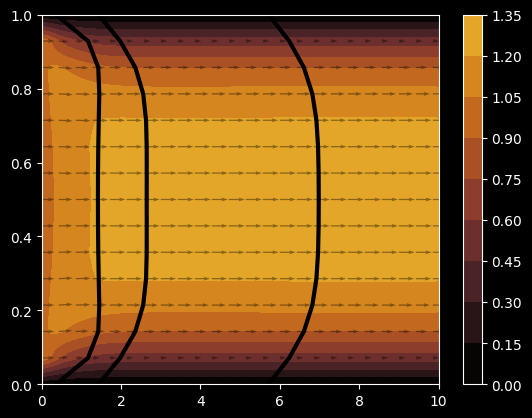

 21%|████████████████▏                                                            | 1051/5000 [00:07<00:27, 142.86it/s]

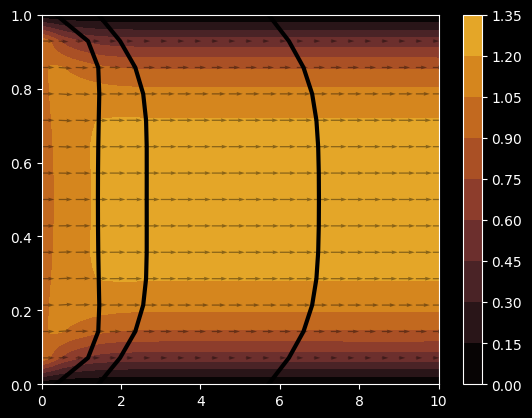

 22%|████████████████▉                                                            | 1101/5000 [00:08<00:26, 147.37it/s]

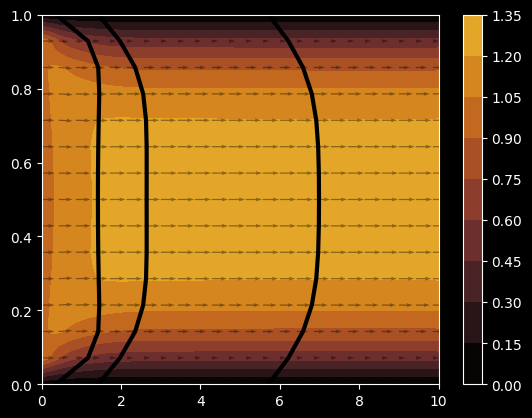

 23%|█████████████████▋                                                           | 1151/5000 [00:08<00:25, 151.31it/s]

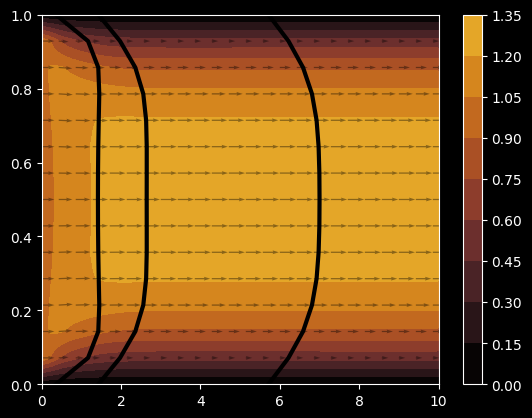

 24%|██████████████████▍                                                          | 1201/5000 [00:08<00:25, 151.53it/s]

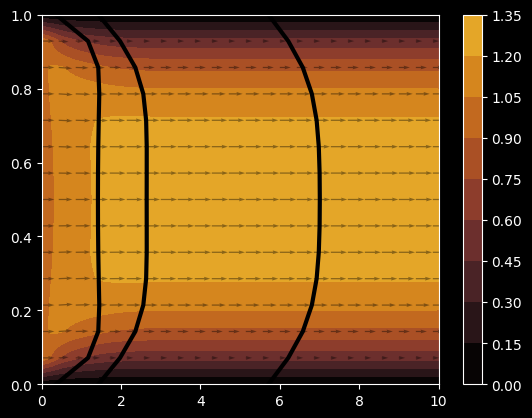

 25%|███████████████████▎                                                         | 1251/5000 [00:09<00:26, 143.69it/s]

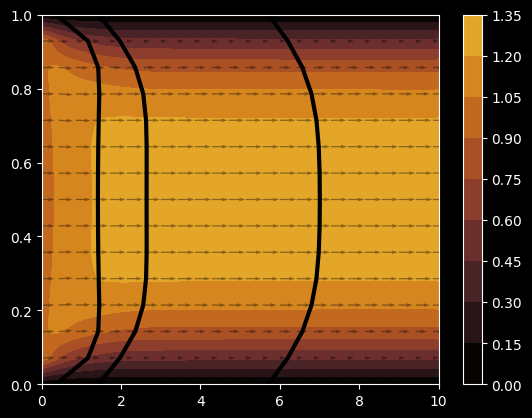

 26%|████████████████████                                                         | 1301/5000 [00:09<00:26, 141.94it/s]

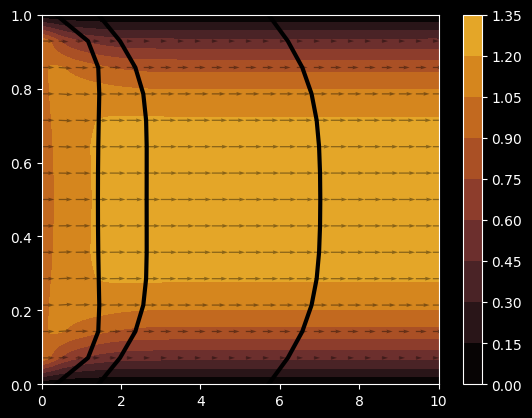

 27%|████████████████████▊                                                        | 1351/5000 [00:09<00:25, 145.35it/s]

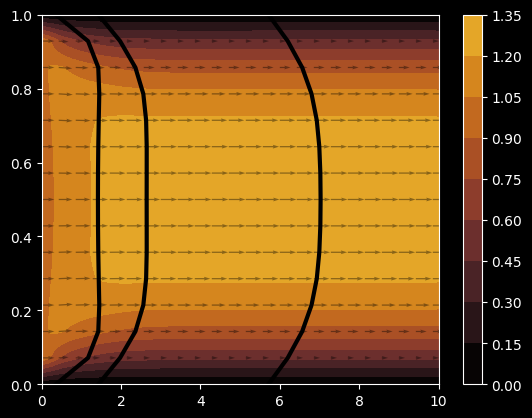

 28%|█████████████████████▌                                                       | 1401/5000 [00:10<00:25, 143.51it/s]

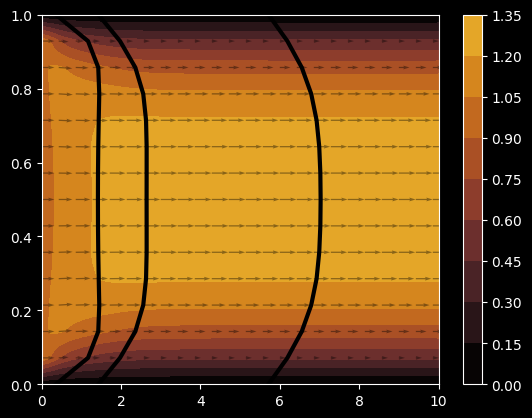

 29%|██████████████████████▎                                                      | 1451/5000 [00:10<00:25, 140.38it/s]

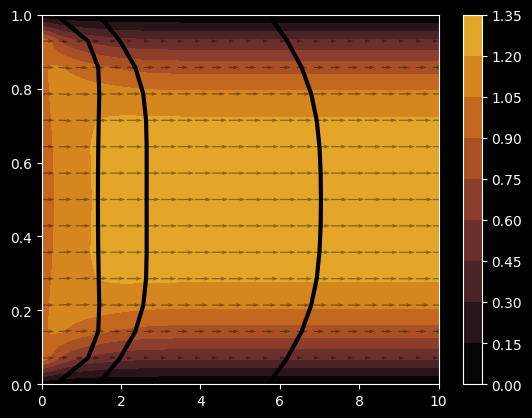

 30%|███████████████████████                                                      | 1501/5000 [00:11<00:24, 140.28it/s]

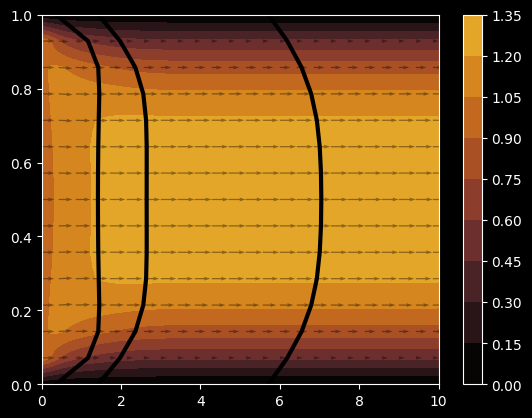

 31%|███████████████████████▉                                                     | 1551/5000 [00:11<00:24, 143.64it/s]

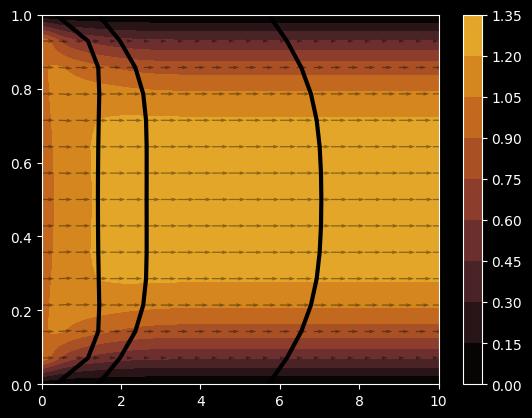

 32%|████████████████████████▋                                                    | 1601/5000 [00:11<00:23, 143.78it/s]

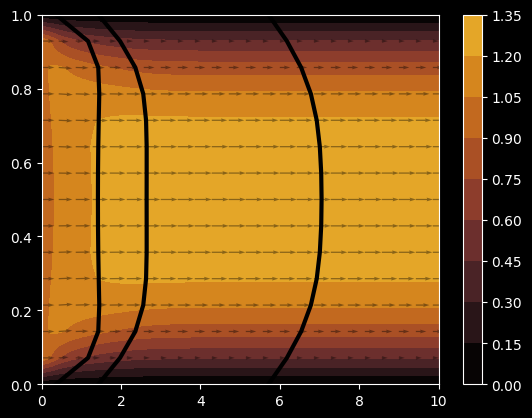

 33%|█████████████████████████▍                                                   | 1651/5000 [00:12<00:23, 142.23it/s]

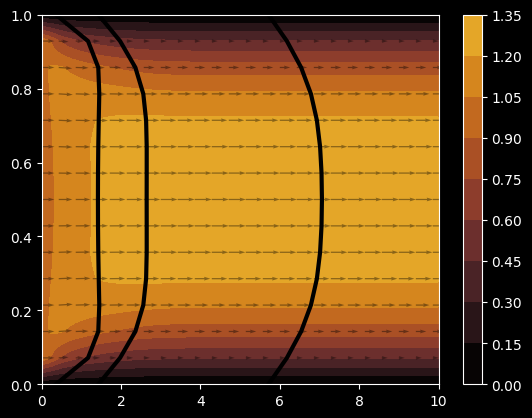

 34%|██████████████████████████▏                                                  | 1701/5000 [00:12<00:24, 134.36it/s]

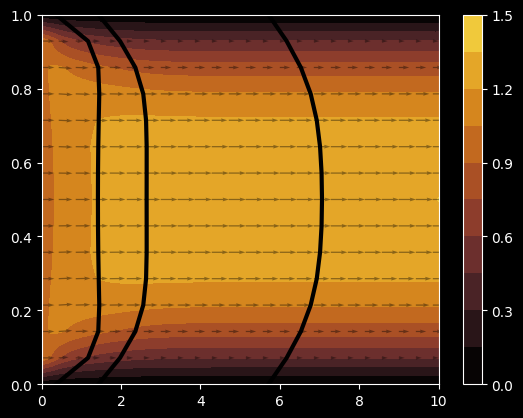

 35%|██████████████████████████▉                                                  | 1751/5000 [00:12<00:23, 141.20it/s]

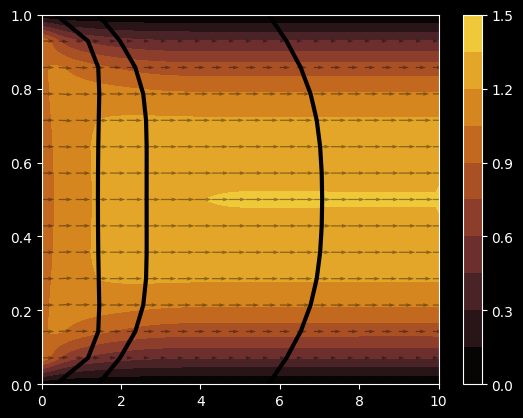

 36%|███████████████████████████▋                                                 | 1801/5000 [00:13<00:21, 146.75it/s]

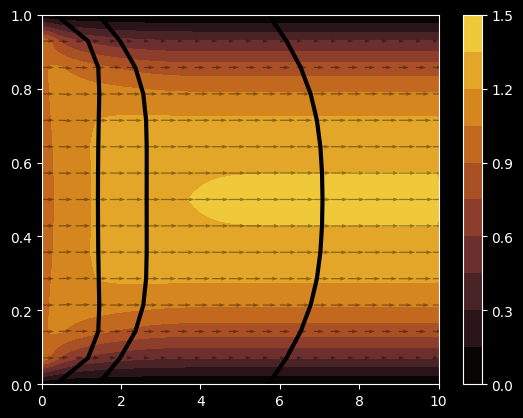

 37%|████████████████████████████▌                                                | 1851/5000 [00:13<00:20, 150.64it/s]

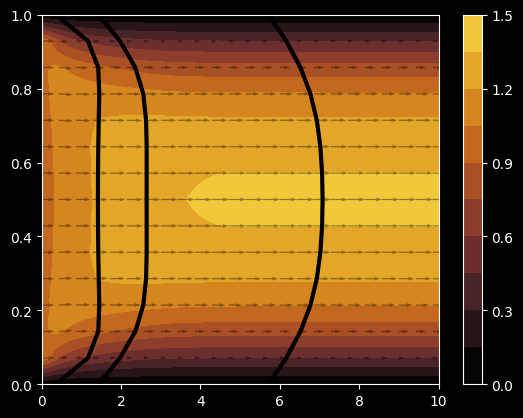

 38%|█████████████████████████████▎                                               | 1901/5000 [00:13<00:19, 155.61it/s]

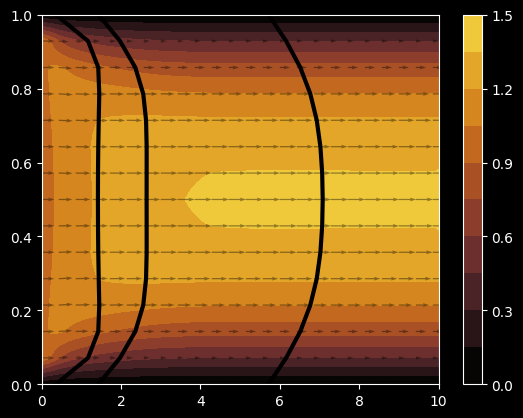

 39%|██████████████████████████████                                               | 1951/5000 [00:14<00:19, 157.20it/s]

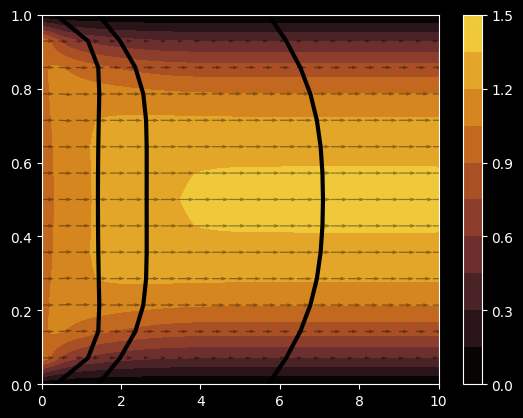

 40%|██████████████████████████████▊                                              | 2001/5000 [00:14<00:18, 158.01it/s]

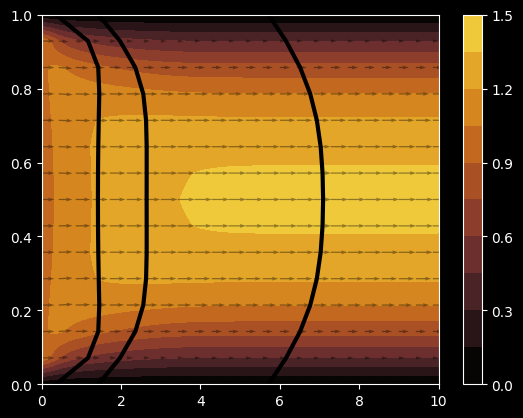

 41%|███████████████████████████████▌                                             | 2051/5000 [00:14<00:18, 156.32it/s]

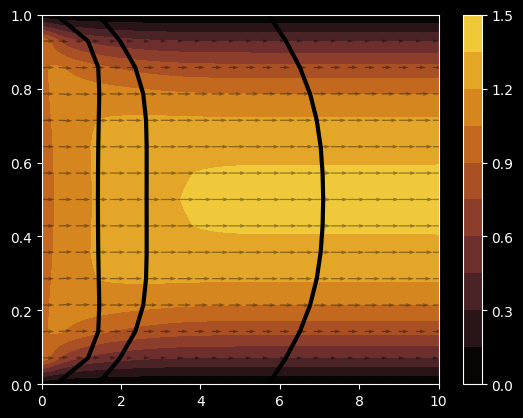

 42%|████████████████████████████████▎                                            | 2101/5000 [00:15<00:18, 155.00it/s]

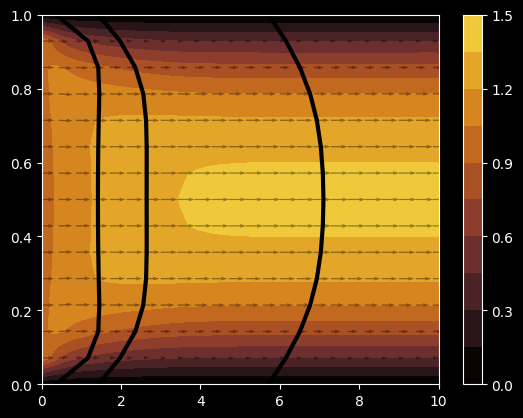

 43%|█████████████████████████████████▏                                           | 2151/5000 [00:15<00:19, 147.46it/s]

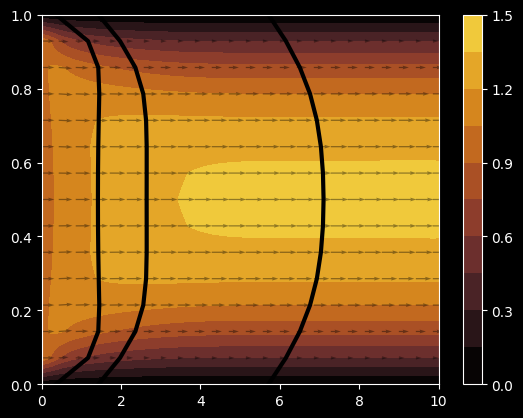

 44%|█████████████████████████████████▉                                           | 2201/5000 [00:15<00:18, 153.09it/s]

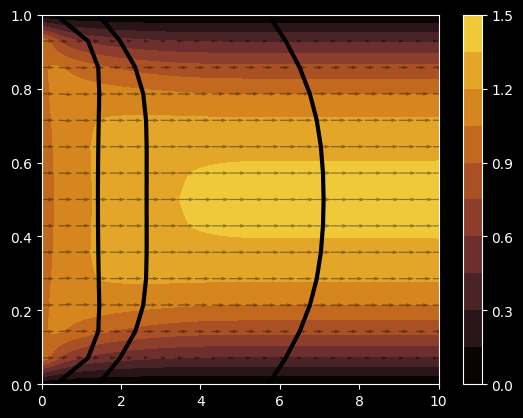

 45%|██████████████████████████████████▋                                          | 2251/5000 [00:16<00:17, 155.67it/s]

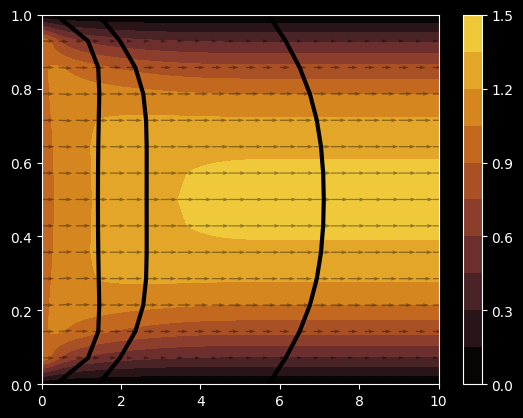

 46%|███████████████████████████████████▍                                         | 2301/5000 [00:16<00:17, 156.62it/s]

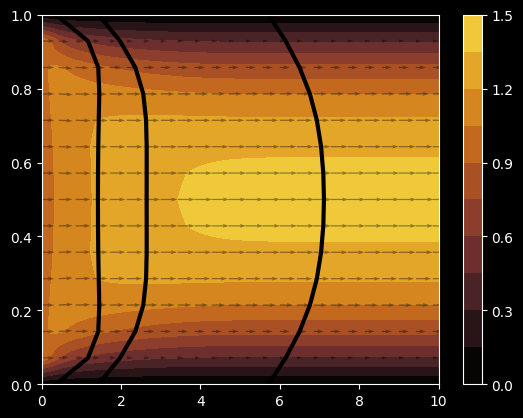

 47%|████████████████████████████████████▏                                        | 2351/5000 [00:16<00:16, 157.90it/s]

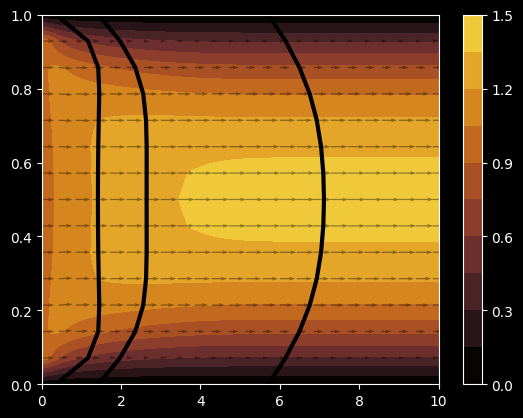

 48%|████████████████████████████████████▉                                        | 2401/5000 [00:16<00:16, 158.07it/s]

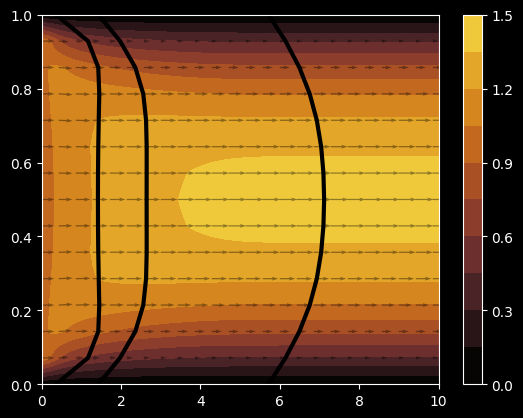

 49%|█████████████████████████████████████▋                                       | 2451/5000 [00:17<00:16, 158.83it/s]

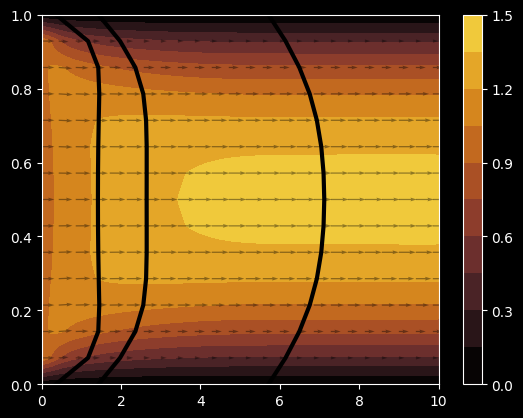

 50%|██████████████████████████████████████▌                                      | 2501/5000 [00:17<00:15, 156.95it/s]

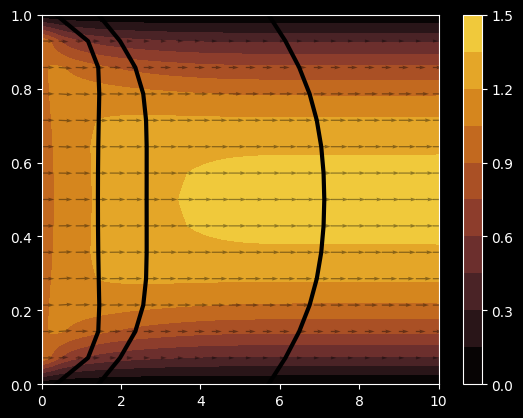

 51%|███████████████████████████████████████▎                                     | 2551/5000 [00:17<00:15, 153.29it/s]

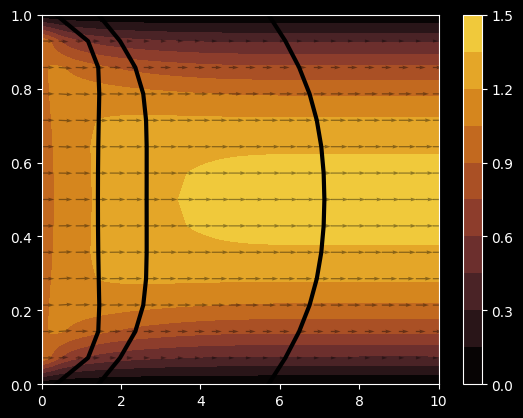

 52%|████████████████████████████████████████                                     | 2601/5000 [00:18<00:16, 144.80it/s]

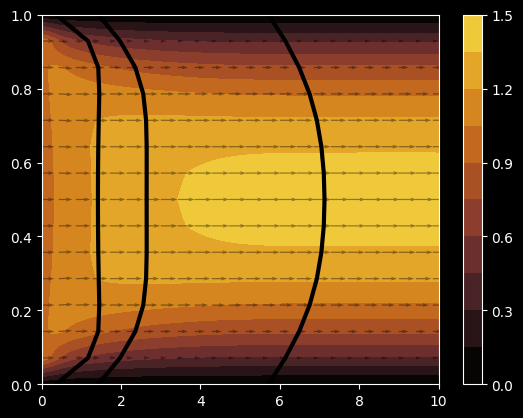

 53%|████████████████████████████████████████▊                                    | 2651/5000 [00:18<00:16, 141.30it/s]

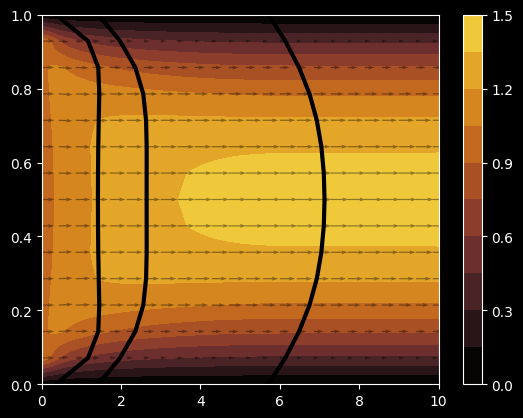

 54%|█████████████████████████████████████████▌                                   | 2701/5000 [00:19<00:15, 145.98it/s]

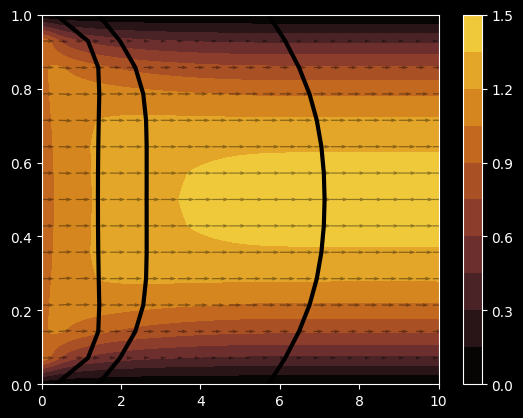

 55%|██████████████████████████████████████████▎                                  | 2751/5000 [00:19<00:15, 148.58it/s]

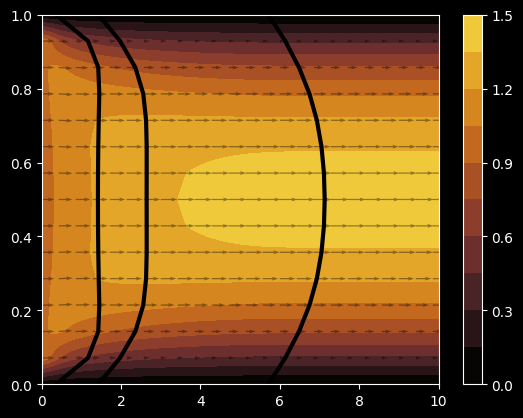

 56%|███████████████████████████████████████████▏                                 | 2801/5000 [00:19<00:14, 152.15it/s]

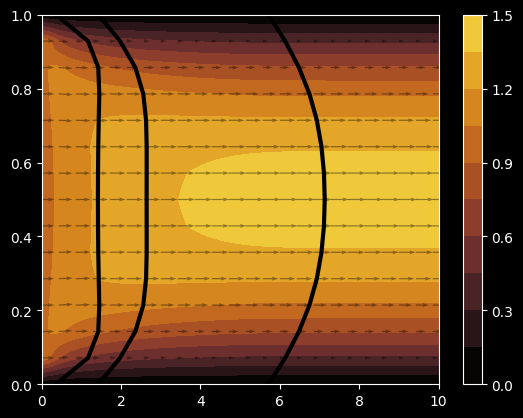

 57%|███████████████████████████████████████████▉                                 | 2851/5000 [00:19<00:14, 150.67it/s]

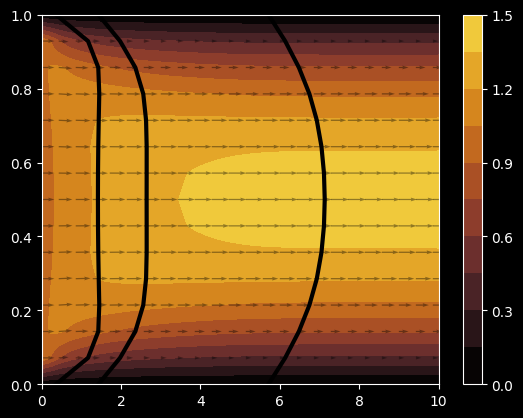

 58%|████████████████████████████████████████████▋                                | 2901/5000 [00:20<00:14, 147.13it/s]

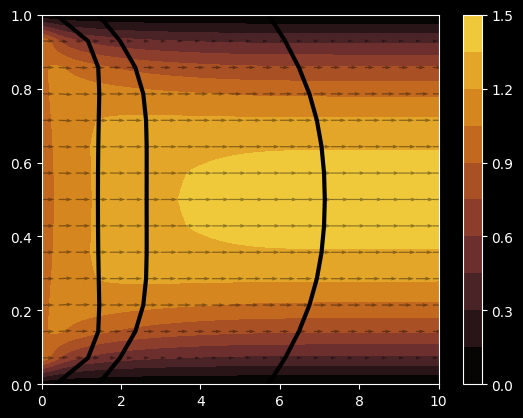

 59%|█████████████████████████████████████████████▍                               | 2951/5000 [00:20<00:13, 146.55it/s]

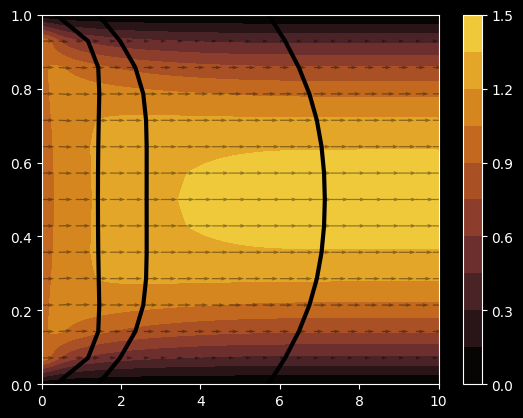

 60%|██████████████████████████████████████████████▏                              | 3001/5000 [00:21<00:14, 137.41it/s]

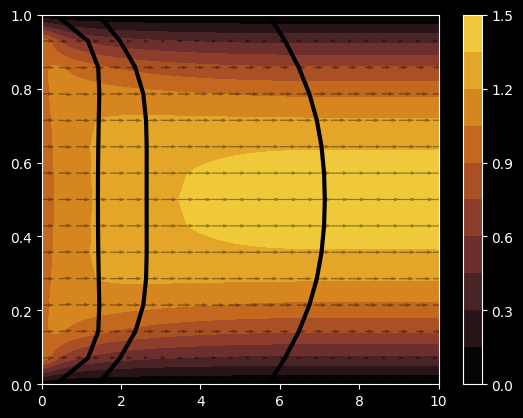

 61%|██████████████████████████████████████████████▉                              | 3051/5000 [00:21<00:13, 143.23it/s]

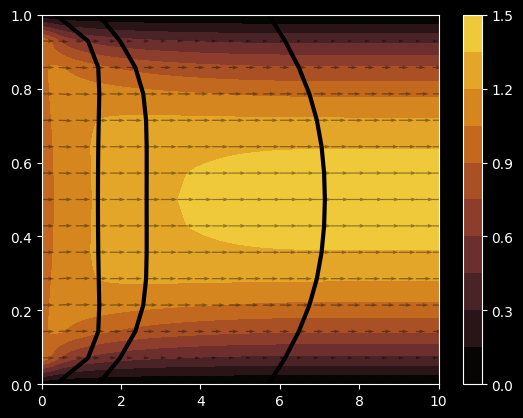

 62%|███████████████████████████████████████████████▊                             | 3101/5000 [00:21<00:12, 147.89it/s]

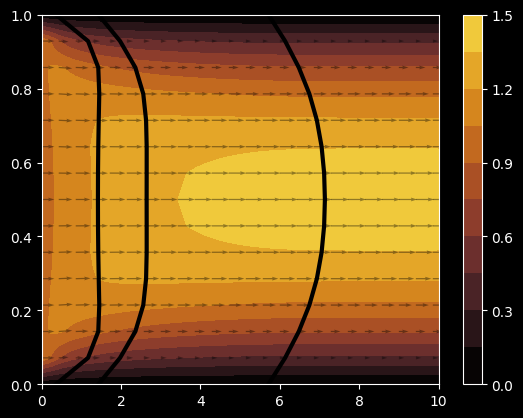

 63%|████████████████████████████████████████████████▌                            | 3151/5000 [00:22<00:12, 153.32it/s]

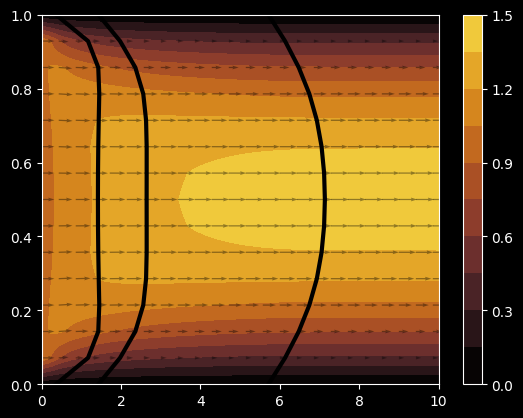

 64%|█████████████████████████████████████████████████▎                           | 3201/5000 [00:22<00:11, 157.62it/s]

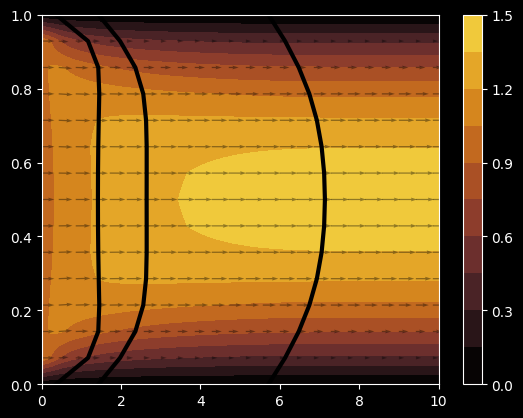

 65%|██████████████████████████████████████████████████                           | 3251/5000 [00:22<00:10, 160.82it/s]

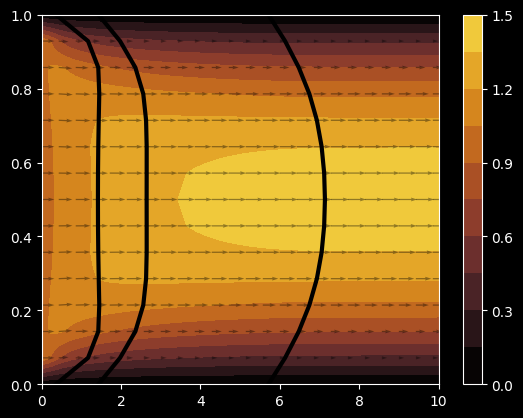

 66%|██████████████████████████████████████████████████▊                          | 3301/5000 [00:22<00:10, 160.45it/s]

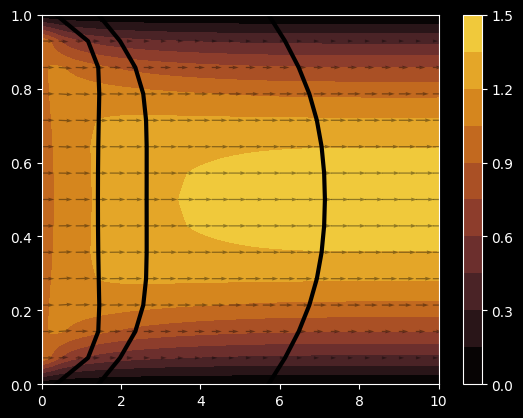

 67%|███████████████████████████████████████████████████▌                         | 3351/5000 [00:23<00:10, 157.94it/s]

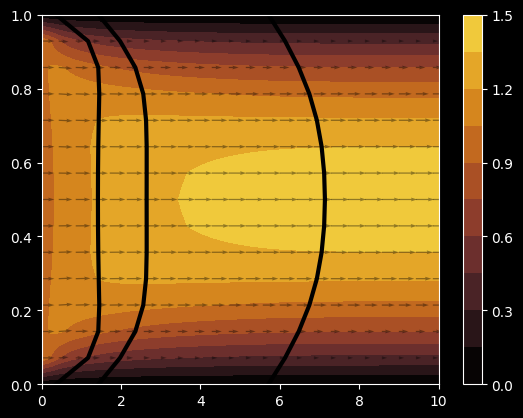

 68%|████████████████████████████████████████████████████▍                        | 3401/5000 [00:23<00:10, 156.55it/s]

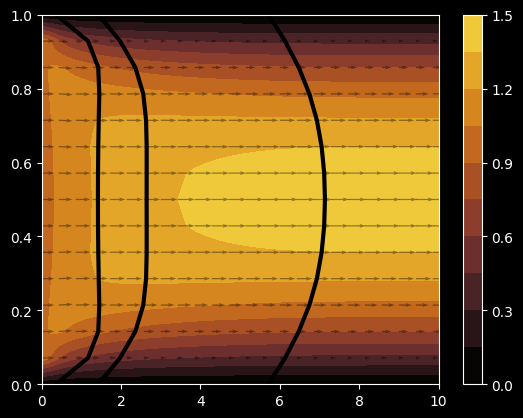

 69%|█████████████████████████████████████████████████████▏                       | 3451/5000 [00:24<00:10, 144.52it/s]

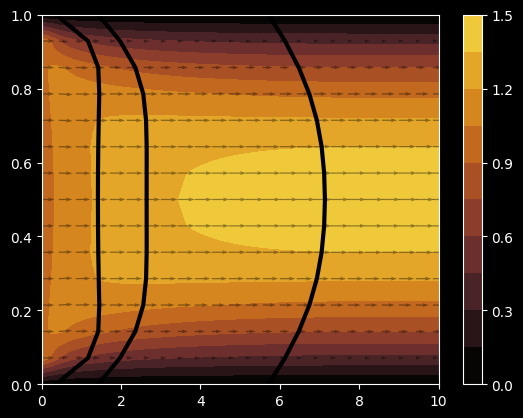

 70%|█████████████████████████████████████████████████████▉                       | 3501/5000 [00:24<00:10, 145.18it/s]

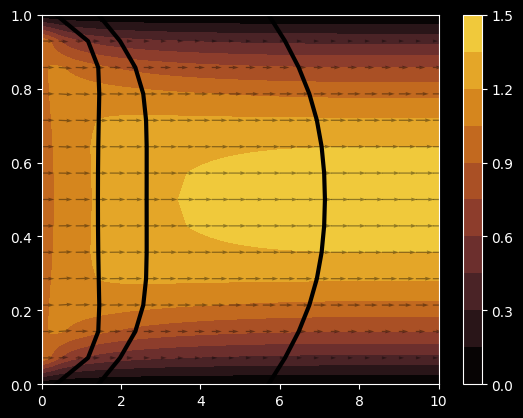

 71%|██████████████████████████████████████████████████████▋                      | 3551/5000 [00:24<00:09, 145.09it/s]

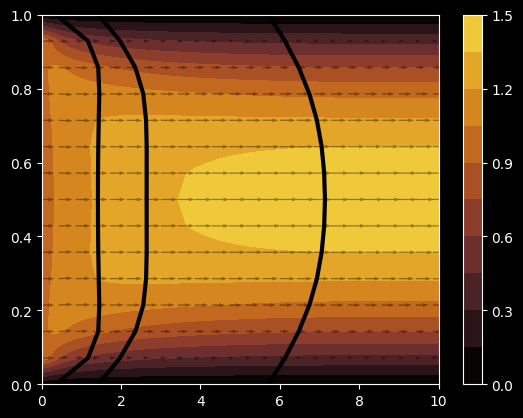

 72%|███████████████████████████████████████████████████████▍                     | 3601/5000 [00:25<00:09, 149.21it/s]

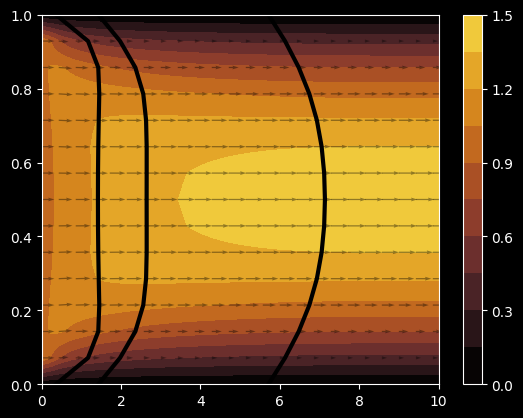

 73%|████████████████████████████████████████████████████████▏                    | 3651/5000 [00:25<00:08, 150.18it/s]

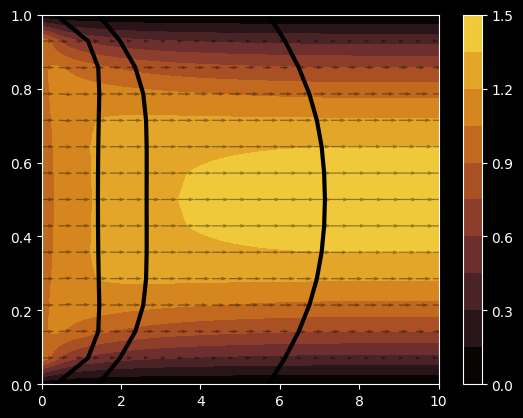

 74%|████████████████████████████████████████████████████████▉                    | 3701/5000 [00:25<00:08, 153.19it/s]

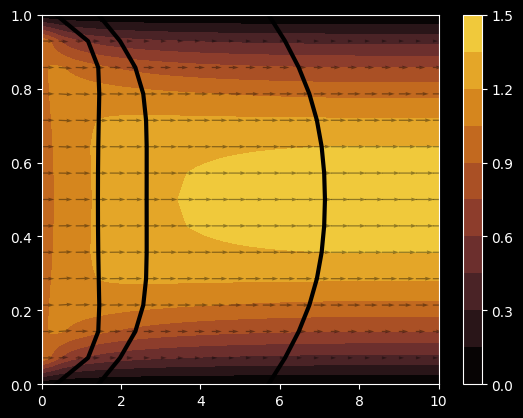

 75%|█████████████████████████████████████████████████████████▊                   | 3751/5000 [00:25<00:08, 153.14it/s]

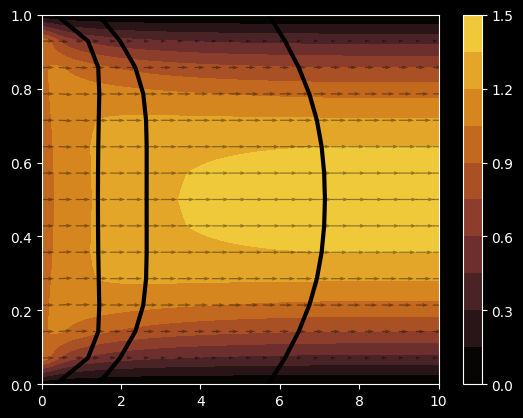

 76%|██████████████████████████████████████████████████████████▌                  | 3801/5000 [00:26<00:07, 152.47it/s]

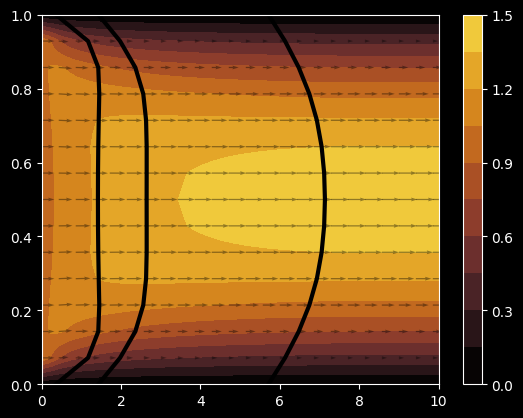

 77%|███████████████████████████████████████████████████████████▎                 | 3851/5000 [00:26<00:07, 152.94it/s]

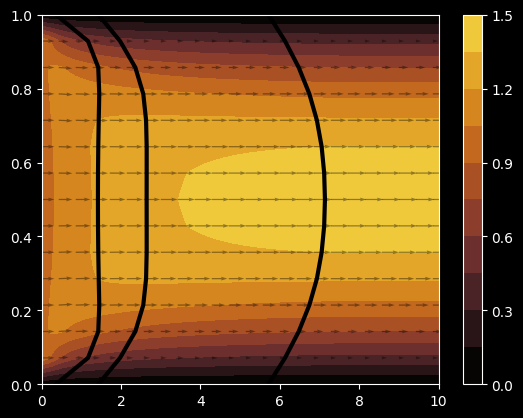

 78%|████████████████████████████████████████████████████████████                 | 3901/5000 [00:27<00:07, 142.64it/s]

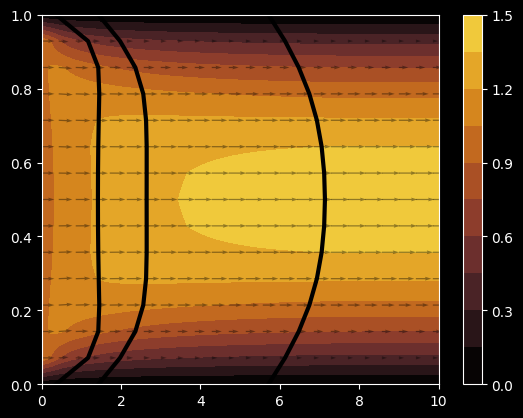

 79%|████████████████████████████████████████████████████████████▊                | 3951/5000 [00:27<00:07, 144.09it/s]

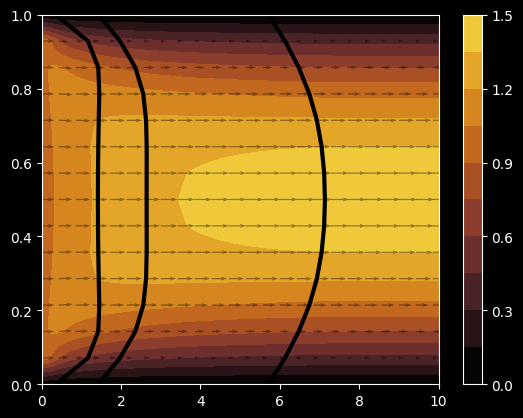

 80%|█████████████████████████████████████████████████████████████▌               | 4001/5000 [00:27<00:06, 146.55it/s]

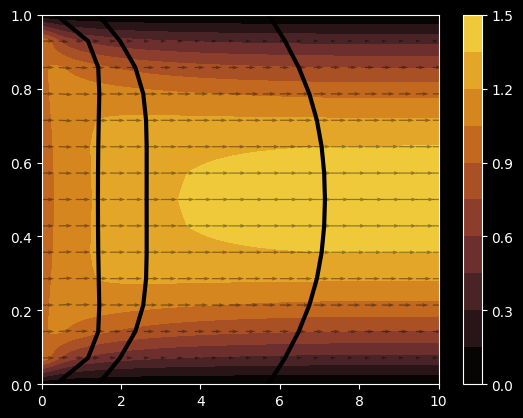

 81%|██████████████████████████████████████████████████████████████▍              | 4051/5000 [00:28<00:06, 148.00it/s]

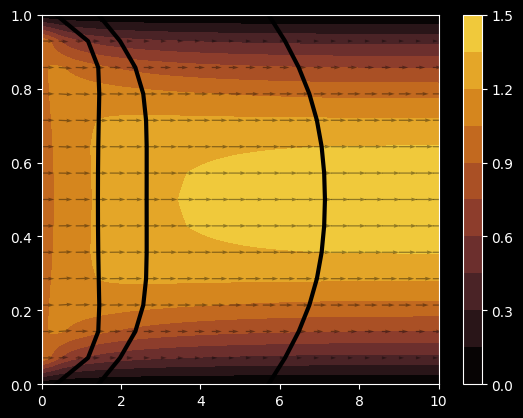

 82%|███████████████████████████████████████████████████████████████▏             | 4101/5000 [00:28<00:06, 149.42it/s]

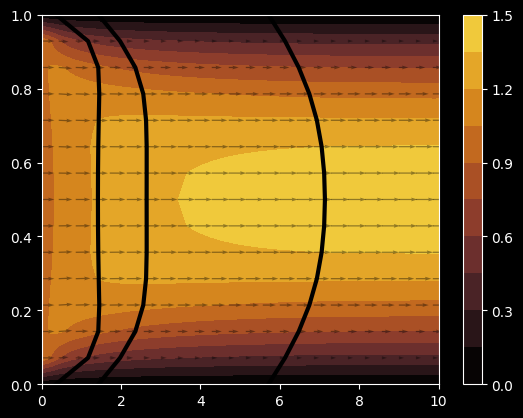

 83%|███████████████████████████████████████████████████████████████▉             | 4151/5000 [00:28<00:05, 150.49it/s]

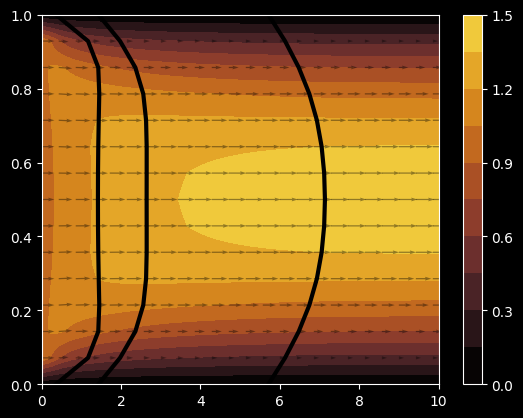

 84%|████████████████████████████████████████████████████████████████▋            | 4201/5000 [00:29<00:05, 148.88it/s]

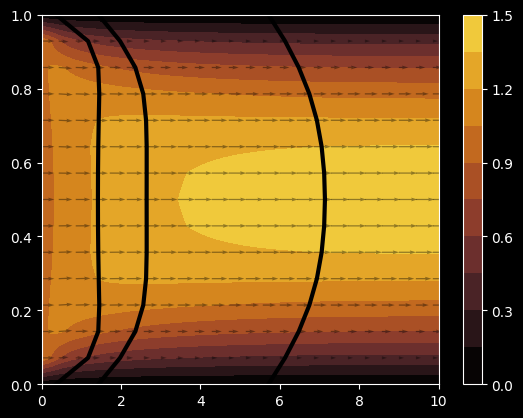

 85%|█████████████████████████████████████████████████████████████████▍           | 4251/5000 [00:29<00:04, 152.14it/s]

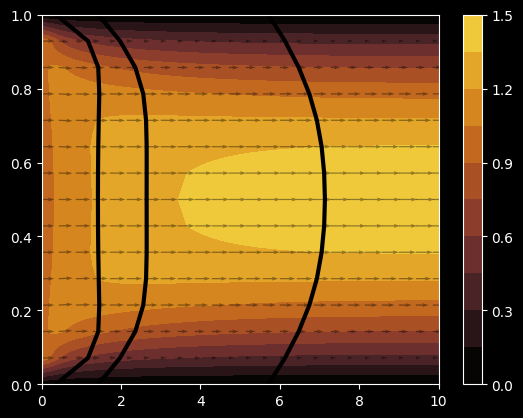

 87%|██████████████████████████████████████████████████████████████████▉          | 4350/5000 [00:29<00:04, 145.65it/s]


KeyboardInterrupt: 

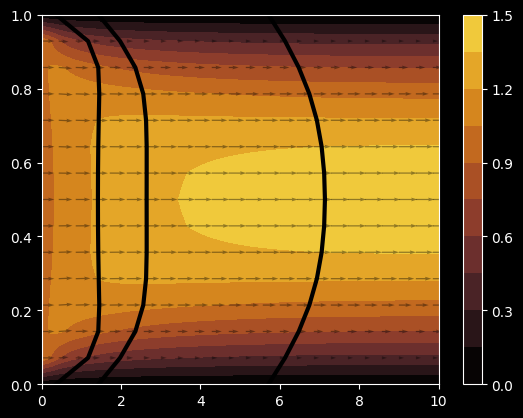

In [3]:
main()

In [1]:
import numpy as np
import scipy.sparse.linalg as splinalg
from scipy import interpolate
import matplotlib.pyplot as plt

# Optional
import cmasher as cmr
from tqdm import tqdm

DOMAIN_SIZE = 1.0
N_POINTS = 41
N_TIME_STEPS = 100
TIME_STEP_LENGTH = 0.1

KINEMATIC_VISCOSITY = 0.0001

MAX_ITER_CG = None

def forcing_function(time, point):
    time_decay = np.maximum(
        2.0 - 0.5 * time,
        0.0,
    )

    forced_value = (
        time_decay
        *
        np.where(
            (
                (point[0] > 0.4)
                &
                (point[0] < 0.6)
                &
                (point[1] > 0.1)
                &
                (point[1] < 0.3)
            ),
            np.array([0.0, 1.0]),
            np.array([0.0, 0.0]),
        )
    )

    return forced_value


def main():
    element_length = DOMAIN_SIZE / (N_POINTS - 1)
    scalar_shape = (N_POINTS, N_POINTS)
    scalar_dof = N_POINTS**2
    vector_shape = (N_POINTS, N_POINTS, 2)
    vector_dof = N_POINTS**2 * 2

    x = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)
    y = np.linspace(0.0, DOMAIN_SIZE, N_POINTS)

    # Using "ij" indexing makes the differential operators more logical. Take
    # care when plotting.
    X, Y = np.meshgrid(x, y, indexing="ij")

    coordinates = np.concatenate(
        (
            X[..., np.newaxis],
            Y[..., np.newaxis],
        ),
        axis=-1,
    )

    forcing_function_vectorized = np.vectorize(
        pyfunc=forcing_function,
        signature="(),(d)->(d)",
    )

    def partial_derivative_x(field):
        diff = np.zeros_like(field)

        diff[1:-1, 1:-1] = (
            (
                field[2:  , 1:-1]
                -
                field[0:-2, 1:-1]
            ) / (
                2 * element_length
            )
        )

        return diff

    def partial_derivative_y(field):
        diff = np.zeros_like(field)

        diff[1:-1, 1:-1] = (
            (
                field[1:-1, 2:  ]
                -
                field[1:-1, 0:-2]
            ) / (
                2 * element_length
            )
        )

        return diff

    def laplace(field):
        diff = np.zeros_like(field)

        diff[1:-1, 1:-1] = (
            (
                field[0:-2, 1:-1]
                +
                field[1:-1, 0:-2]
                - 4 *
                field[1:-1, 1:-1]
                +
                field[2:  , 1:-1]
                +
                field[1:-1, 2:  ]
            ) / (
                element_length**2
            )
        )

        return diff
    
    def divergence(vector_field):
        divergence_applied = (
            partial_derivative_x(vector_field[..., 0])
            +
            partial_derivative_y(vector_field[..., 1])
        )

        return divergence_applied
    
    def gradient(field):
        gradient_applied = np.concatenate(
            (
                partial_derivative_x(field)[..., np.newaxis],
                partial_derivative_y(field)[..., np.newaxis],
            ),
            axis=-1,
        )

        return gradient_applied
    
    def curl_2d(vector_field):
        curl_applied = (
            partial_derivative_x(vector_field[..., 1])
            -
            partial_derivative_y(vector_field[..., 0])
        )

        return curl_applied

    def advect(field, vector_field):
        backtraced_positions = np.clip(
            (
                coordinates
                -
                TIME_STEP_LENGTH
                *
                vector_field
            ),
            0.0,
            DOMAIN_SIZE,
        )

        advected_field = interpolate.interpn(
            points=(x, y),
            values=field,
            xi=backtraced_positions,
        )

        return advected_field
    
    def diffusion_operator(vector_field_flattened):
        vector_field = vector_field_flattened.reshape(vector_shape)

        diffusion_applied = (
            vector_field
            -
            KINEMATIC_VISCOSITY
            *
            TIME_STEP_LENGTH
            *
            laplace(vector_field)
        )

        return diffusion_applied.flatten()
    
    def poisson_operator(field_flattened):
        field = field_flattened.reshape(scalar_shape)

        poisson_applied = laplace(field)

        return poisson_applied.flatten()

    plt.style.use("dark_background")
    plt.figure(figsize=(5, 5), dpi=160)

    velocities_prev = np.zeros(vector_shape)
    
    time_current = 0.0
    for i in tqdm(range(N_TIME_STEPS)):
        time_current += TIME_STEP_LENGTH

        forces = forcing_function_vectorized(
            time_current,
            coordinates,
        )

        # (1) Apply Forces
        velocities_forces_applied = (
            velocities_prev
            +
            TIME_STEP_LENGTH
            *
            forces
        )

        # (2) Nonlinear convection (=self-advection)
        velocities_advected = advect(
            field=velocities_forces_applied,
            vector_field=velocities_forces_applied,
        )

        # (3) Diffuse
        velocities_diffused = splinalg.cg(
            A=splinalg.LinearOperator(
                shape=(vector_dof, vector_dof),
                matvec=diffusion_operator,
            ),
            b=velocities_advected.flatten(),
            maxiter=MAX_ITER_CG,
        )[0].reshape(vector_shape)

        # (4.1) Compute a pressure correction
        pressure = splinalg.cg(
            A=splinalg.LinearOperator(
                shape=(scalar_dof, scalar_dof),
                matvec=poisson_operator,
            ),
            b=divergence(velocities_diffused).flatten(),
            maxiter=MAX_ITER_CG,
        )[0].reshape(scalar_shape)

        # (4.2) Correct the velocities to be incompressible
        velocities_projected = (
            velocities_diffused
            -
            gradient(pressure)
        )

        # Advance to next time step
        velocities_prev = velocities_projected

        # Plot
        curl = curl_2d(velocities_projected)
        plt.contourf(
            X,
            Y,
            curl,
            cmap=cmr.redshift,
            levels=100,
        )
        plt.quiver(
            X, 
            Y,
            velocities_projected[..., 0],
            velocities_projected[..., 1],
            color="dimgray",
        )
        plt.draw()
        plt.pause(0.0001)
        plt.clf()

    plt.show()
        


# if __name__ == "__main__":
#     main()